In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

## Defining Resuable columns

In [28]:
def display_correlation_matrix(df, columns=None):
    # If no columns are specified, use all numeric columns
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Calculate the correlation matrix
    corr_matrix = df[columns].corr().fillna(0)
    
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

In [118]:
def check_correlations_with_categorical_target(df, feature_columns, target_column):
    results = []
    
    for col in feature_columns:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue
            
        # Only use rows where both column and target are not null
        valid_data = df[[col, target_column]].dropna()
        if len(valid_data) == 0:
            continue
            
        # Group by target and calculate mean for each feature
        grouped = valid_data.groupby(target_column)[col].mean()
        
        # Calculate correlation ratio correctly
        overall_mean = valid_data[col].mean()
        total_sum_squares = ((valid_data[col] - overall_mean) ** 2).sum()
        
        if total_sum_squares == 0:  # Avoid division by zero
            eta = 0
        else:
            between_sum_squares = sum([(grouped[cat] - overall_mean) ** 2 * 
                                      (valid_data[target_column] == cat).sum() 
                                      for cat in grouped.index])
            eta = np.sqrt(between_sum_squares / total_sum_squares)
            
            # Ensure value is between 0 and 1
            eta = min(1.0, max(0.0, eta))
            
        results.append({'Feature': col, 'Correlation': eta})
    
    corr_df = pd.DataFrame(results)
    corr_df = corr_df.sort_values('Correlation', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Correlation', y='Feature', data=corr_df)
    plt.title(f'Association with {target_column} (Eta Coefficient)')
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    return corr_df

In [72]:
def visualize_group_correlations_categorical(merged_df, watch_df):
    columns = watch_df.columns
    # Filter dataframe to include only rows where 'sii' is not null
    filtered_df = merged_df.dropna(subset=['sii'])
    # Remove constant columns
    valid_columns = []
    for col in columns:
        if col in filtered_df.columns and pd.api.types.is_numeric_dtype(filtered_df[col]):
            try:
                if filtered_df[col].std() > 0:
                    valid_columns.append(col)
            except:
                continue
    # Group columns by prefix
    groups = {
       'anglez': [col for col in valid_columns if col.startswith('anglez')],
       'enmo': [col for col in valid_columns if col.startswith('enmo')],
       'light': [col for col in valid_columns if col.startswith('light')],
       'X': [col for col in valid_columns if col.startswith('X_')],
       'Y': [col for col in valid_columns if col.startswith('Y_')],
       'Z': [col for col in valid_columns if col.startswith('Z_')]
    }
    # Create a subplot grid
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()
    # Plot correlations for each group
    for i, (prefix, cols) in enumerate(groups.items()):
       if not cols:
           axes[i].text(0.5, 0.5, f"No valid {prefix} columns", 
                        ha='center', va='center', fontsize=12)
           axes[i].set_title(f'{prefix} Features')
           continue
           
       correlations = {}
       for col in cols:
           # Calculate correlation ratio for categorical target
           grouped = filtered_df.groupby('sii')[col].mean()
           overall_mean = filtered_df[col].mean()
           total_sum_squares = ((filtered_df[col] - overall_mean) ** 2).sum()
           between_sum_squares = sum([(grouped[cat] - overall_mean) ** 2 * (filtered_df['sii'] == cat).sum() 
                                     for cat in grouped.index])
           
           corr = np.sqrt(between_sum_squares / total_sum_squares) if total_sum_squares != 0 else 0
           correlations[col] = corr
       
       corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
       corr_df = corr_df.sort_values('Correlation', ascending=False)
       
       sns.barplot(x='Correlation', y='Feature', data=corr_df, ax=axes[i])
       axes[i].set_title(f'{prefix} Features Association with sii')
       axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
       axes[i].set_xlim(0, 1)  # Correlation ratio is between 0 and 1
       
       if len(corr_df) > 0:
           max_val = corr_df['Correlation'].max()
           # Add a small buffer to the limit
           buffer = 0.05
           axes[i].set_xlim(0, max_val + buffer)
    
    plt.tight_layout()
    plt.show()

In [123]:
def check_missing_data(df):
    # Calculate missing values
    missing = df.isnull().sum()
    
    # Calculate percentage of missing values
    missing_percent = (missing / len(df)) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_percent
    })
    
    # Sort by percentage of missing values (descending)
    return missing_data.sort_values('Percentage', ascending=False)

## Importing Watch Data

In [10]:
watch_df = pd.read_csv(r'data/stat_parquet.csv', index_col=0)
watch_df.head()

,anglez_iqr,anglez_kurtosis,anglez_max,anglez_mean,anglez_median,anglez_min,anglez_mode,anglez_q25,anglez_q75,anglez_range,...,Z_median,Z_min,Z_mode,Z_q25,Z_q75,Z_range,Z_skew,Z_std,Z_var,Z_zero_crossings
0,53.762627,-0.299388,89.751656,-10.580416,-15.086617,-89.833090,87.381520,-41.541863,12.220764,179.58475,...,-0.245378,-1.048372,0.993594,-0.649974,0.204727,2.595352,0.491204,0.585710,0.343056,0
1,76.654536,-1.032515,89.476036,-6.663768,2.383424,-88.749420,-86.118620,-44.786814,31.867723,178.22546,...,0.041833,-1.018787,-1.009070,-0.701514,0.519027,2.165071,-0.121346,0.667302,0.445292,0
2,46.475641,0.464800,89.862820,21.633518,26.167389,-89.463230,-71.387280,2.310668,48.786308,179.32605,...,0.436946,-1.016758,-0.987330,0.040097,0.748744,3.256697,-0.836533,0.533543,0.284668,0
3,53.946782,-0.543494,88.478430,-21.017265,-23.707083,-89.877220,-51.965607,-50.706446,3.240337,178.35565,...,-0.388560,-1.022549,-0.953537,-0.762592,0.059622,2.321842,0.558317,0.522132,0.272621,0
4,57.988619,-0.726616,88.389680,-5.059758,-2.822715,-89.308716,-87.135750,-35.037018,22.951601,177.69840,...,-0.042274,-1.003249,-0.996072,-0.562416,0.394637,3.324513,0.077196,0.578022,0.334110,0


In [11]:
watch_df.shape

(996, 85)

## Importing Train Data

In [12]:
train_df = pd.read_csv(r'data/train.csv')
train_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train_df.shape

(3960, 82)

## Merge 2 DFs

In [54]:
merged_df = pd.merge(train_df, watch_df, on='id', how='left')
merged_df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,Z_median,Z_min,Z_mode,Z_q25,Z_q75,Z_range,Z_skew,Z_std,Z_var,Z_zero_crossings
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,-0.245378,-1.048372,0.993594,-0.649974,0.204727,2.595352,0.491204,0.58571,0.343056,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
merged_df.shape

(3960, 166)

In [56]:
filtered_df = merged_df.dropna(subset=['sii'])
filtered_df.shape

(2736, 166)

In [57]:
stat_keywords = ['mean', 'median', 'min', 'max', 'std']
stat_columns = [col for col in merged_df.columns if any(col.lower().endswith(keyword) for keyword in stat_keywords)]
stat_columns

['anglez_max',
 'anglez_mean',
 'anglez_median',
 'anglez_min',
 'anglez_std',
 'enmo_max',
 'enmo_mean',
 'enmo_median',
 'enmo_min',
 'enmo_std',
 'light_max',
 'light_mean',
 'light_median',
 'light_min',
 'light_std',
 'X_max',
 'X_mean',
 'X_median',
 'X_min',
 'X_std',
 'Y_max',
 'Y_mean',
 'Y_median',
 'Y_min',
 'Y_std',
 'Z_max',
 'Z_mean',
 'Z_median',
 'Z_min',
 'Z_std']

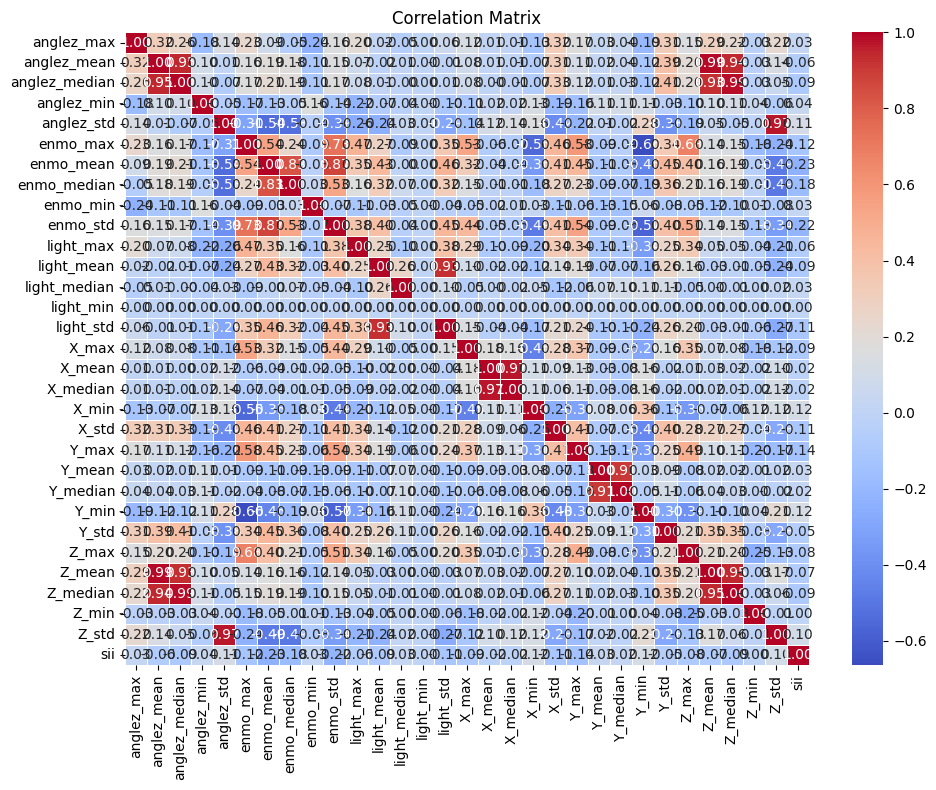

In [58]:
corr = display_correlation_matrix(filtered_df, stat_columns+['sii'])

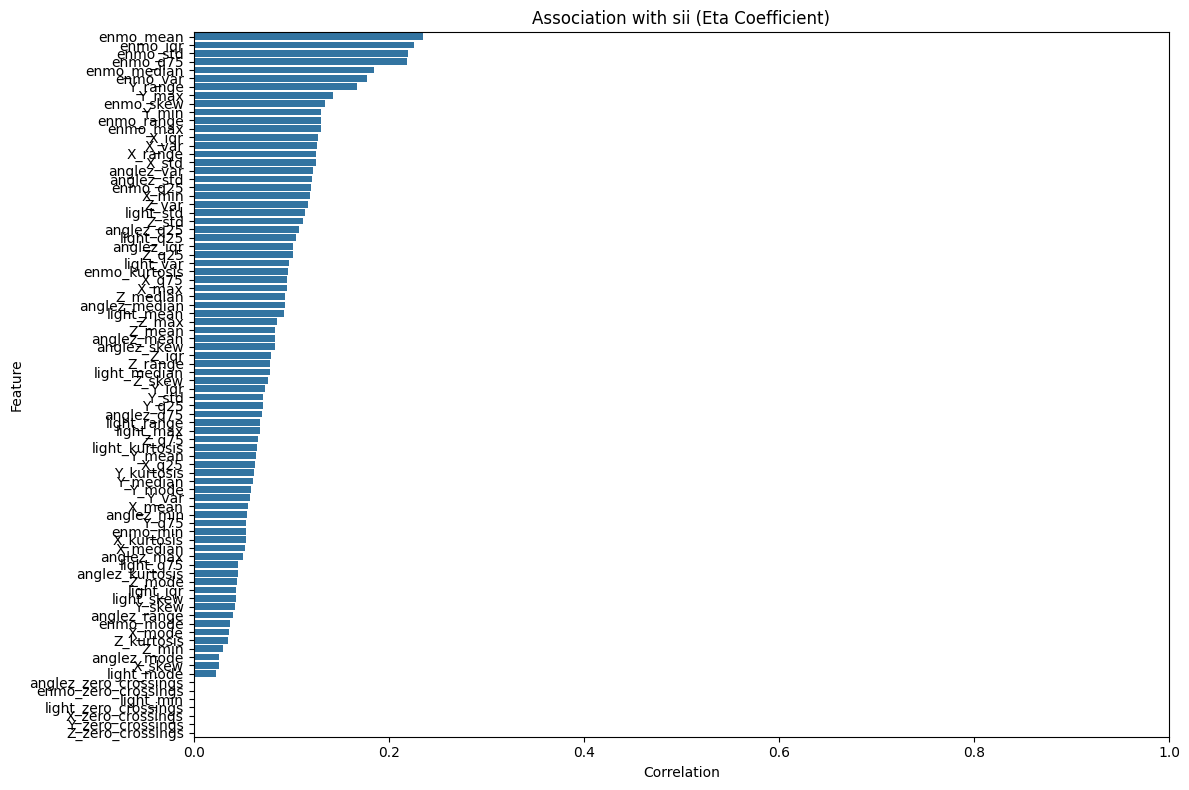

In [121]:
corr = check_correlations_with_categorical_target(filtered_df, watch_df.columns, 'sii')

In [93]:
corr.head(7)

,Feature,Correlation
17,enmo_mean,0.392596
14,enmo_iqr,0.376430
25,enmo_std,0.367420
22,enmo_q75,0.363888
18,enmo_median,0.307652
26,enmo_var,0.294908
65,Y_range,0.286810


In [100]:
rows_to_take = corr[corr['Correlation'] > 0.20]
rows_to_take = list(rows_to_take['Feature'])
rows_to_take

['enmo_mean',
 'enmo_iqr',
 'enmo_std',
 'enmo_q75',
 'enmo_median',
 'enmo_var',
 'Y_range',
 'Y_max',
 'enmo_range',
 'enmo_max',
 'Y_min',
 'enmo_skew',
 'X_iqr',
 'X_var',
 'X_std',
 'X_range',
 'anglez_var',
 'anglez_std',
 'Z_var',
 'X_min',
 'enmo_q25']

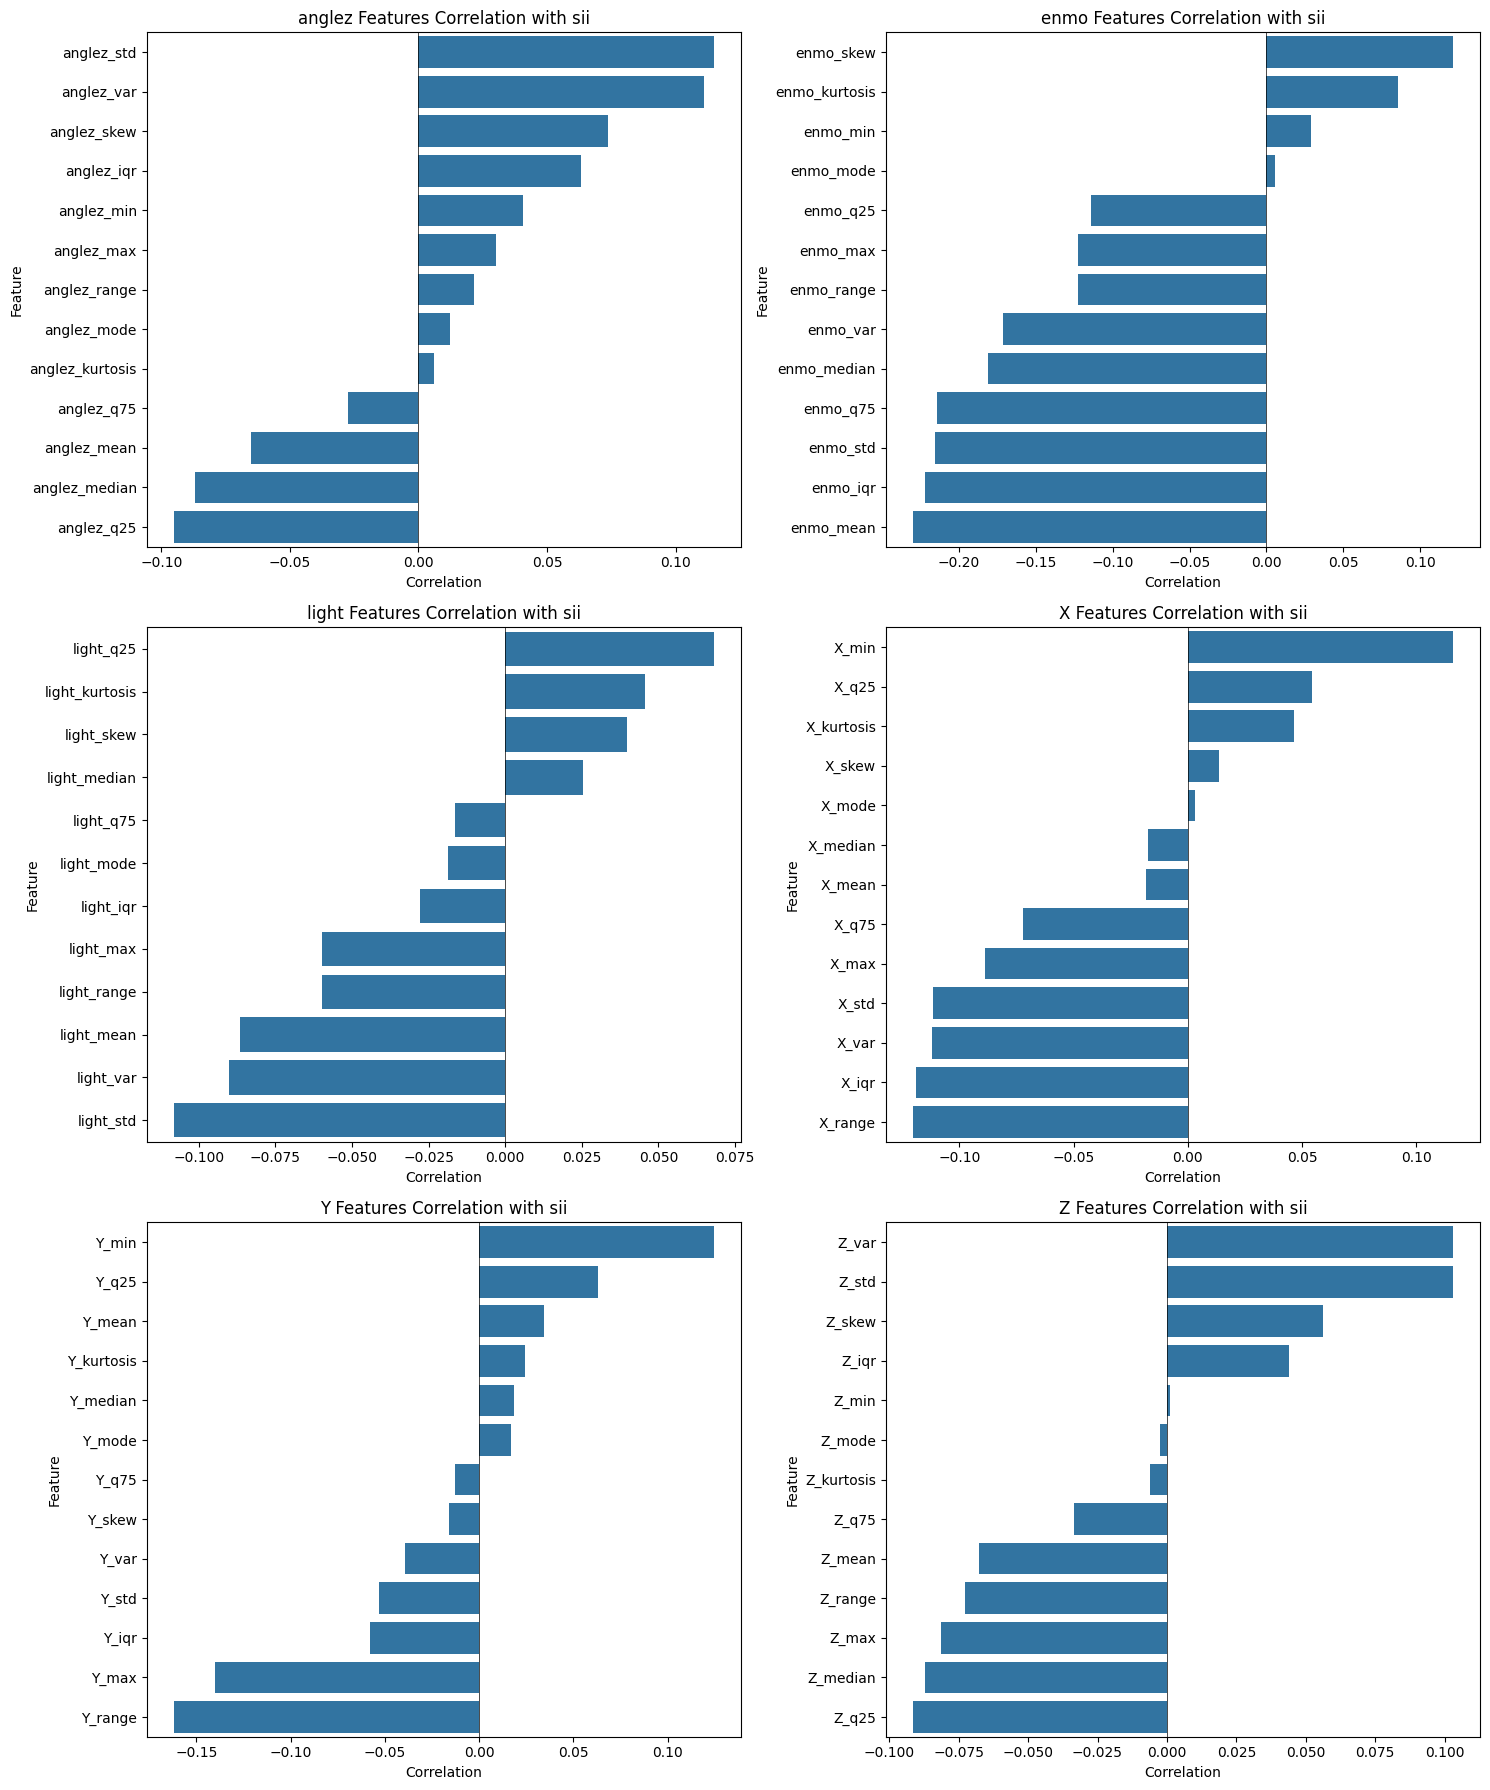

In [86]:
columns = watch_df.columns

# Filter dataframe to include only rows where 'sii' is not null
filtered_df = merged_df.dropna(subset=['sii'])

# Remove constant columns
valid_columns = []
for col in columns:
    if col in filtered_df.columns and pd.api.types.is_numeric_dtype(filtered_df[col]):
        try:
            if filtered_df[col].std() > 0:
                valid_columns.append(col)
        except:
            continue

# Group columns by prefix
groups = {
   'anglez': [col for col in valid_columns if col.startswith('anglez')],
   'enmo': [col for col in valid_columns if col.startswith('enmo')],
   'light': [col for col in valid_columns if col.startswith('light')],
   'X': [col for col in valid_columns if col.startswith('X_')],
   'Y': [col for col in valid_columns if col.startswith('Y_')],
   'Z': [col for col in valid_columns if col.startswith('Z_')]
}

# Create a subplot grid
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# Plot correlations for each group
for i, (prefix, cols) in enumerate(groups.items()):
   if not cols:
       axes[i].text(0.5, 0.5, f"No valid {prefix} columns", 
                    ha='center', va='center', fontsize=12)
       axes[i].set_title(f'{prefix} Features')
       continue
       
   correlations = {}
   for col in cols:
       corr = merged_df[col].corr(merged_df['sii'])
       correlations[col] = 0 if pd.isna(corr) else corr
   
   corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
   corr_df = corr_df.sort_values('Correlation', ascending=False)
   
   sns.barplot(x='Correlation', y='Feature', data=corr_df, ax=axes[i])
   axes[i].set_title(f'{prefix} Features Correlation with sii')
   axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
   axes[i].set_xlim(-1, 1)

    # Set specific limits for each subplot based on actual data
   if len(corr_df) > 0:
       min_val = corr_df['Correlation'].min()
       max_val = corr_df['Correlation'].max()
       # Add a small buffer to the limits
       buffer = 0.05 * (max_val - min_val)
       axes[i].set_xlim(min_val - buffer, max_val + buffer)

plt.tight_layout()
plt.show()

In [103]:
merged_df2 = pd.merge(train_df, watch_df[rows_to_take+['id']], on='id', how='left')
merged_df2.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,enmo_skew,X_iqr,X_var,X_std,X_range,anglez_var,anglez_std,Z_var,X_min,enmo_q25
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,10.136331,0.673503,0.205812,0.453665,3.253958,1844.4595,42.94717,0.343056,-1.746094,0.006432
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
merged_df2.shape

(3960, 103)

## Importing Average Watch DF

In [79]:
avg_df = pd.read_csv(r'data/avg_parquet.csv', index_col = 0)
avg_df.head()

,enmo_h0,enmo_h1,enmo_h10,enmo_h11,enmo_h12,enmo_h13,enmo_h14,enmo_h15,enmo_h16,enmo_h17,...,light_w9,light_w90,light_w91,light_w92,light_w93,light_w94,light_w95,light_w96,light_w97,light_w99
0,0.020952,0.033222,0.046533,0.043808,0.030952,0.065813,0.045689,0.031533,0.058526,0.053016,...,13.224856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002808,0.008027,0.021365,0.023271,0.038819,0.019645,0.030716,0.026229,0.018902,0.023248,...,24.121109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.004010,0.003738,0.049295,0.039044,0.149919,0.073839,0.054163,0.074922,0.045967,0.030919,...,33.663876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.004876,0.004869,0.065006,0.047939,0.047176,0.059867,0.052670,0.047561,0.064359,0.050110,...,13.530785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.005384,0.004706,0.061734,0.050658,0.112435,0.126275,0.078224,0.228003,0.173780,0.066350,...,48.232033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
avg_df.shape

(996, 247)

## Merge

In [105]:
merged_df3 = pd.merge(merged_df2, avg_df, on='id', how='left')
merged_df3.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,light_w9,light_w90,light_w91,light_w92,light_w93,light_w94,light_w95,light_w96,light_w97,light_w99
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,13.224856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
merged_df3.shape

(3960, 349)

In [108]:
filtered_df2 = merged_df3.dropna(subset=['sii'])
filtered_df2.shape

(2736, 349)

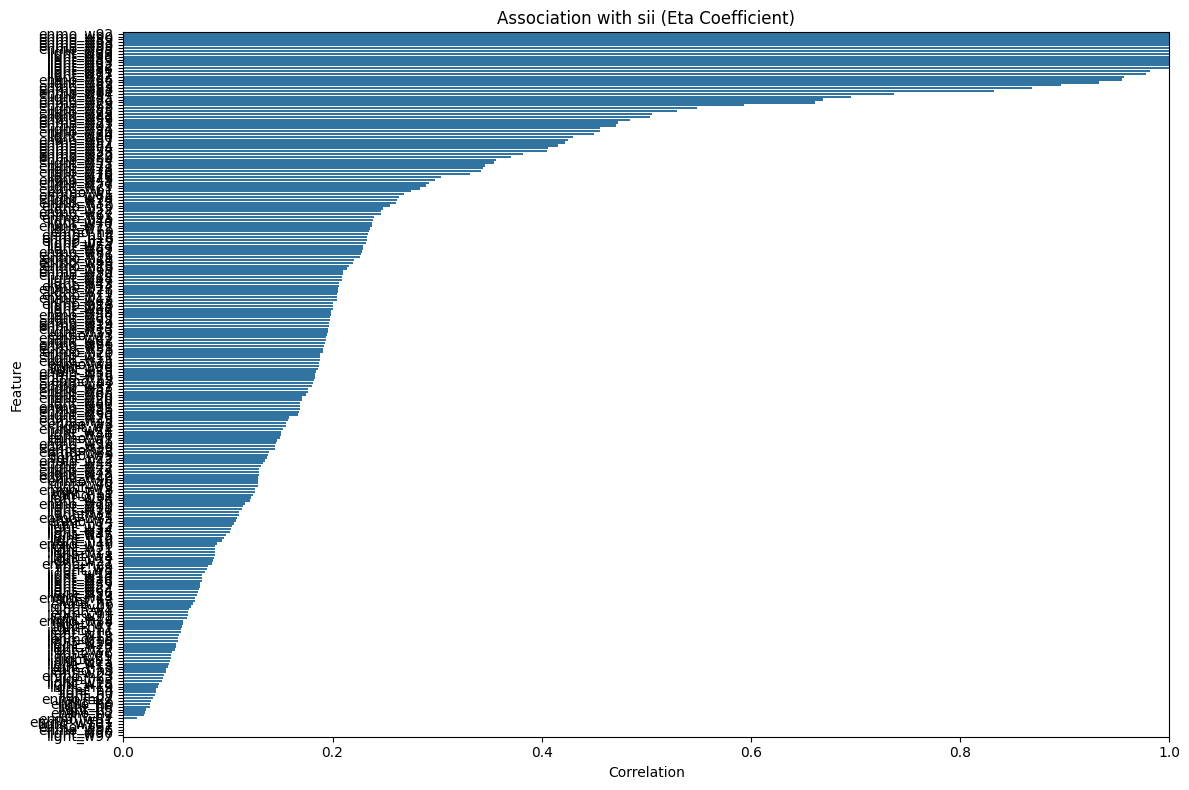

In [119]:
corr = check_correlations_with_categorical_target(filtered_df2, avg_df.columns, 'sii')

In [120]:
corr.head(15)

,Feature,Correlation
116,enmo_w92,1.000000
114,enmo_w90,1.000000
112,enmo_w89,1.000000
117,enmo_w93,1.000000
122,enmo_w99,1.000000
119,enmo_w95,1.000000
242,light_w95,1.000000
245,light_w99,1.000000
237,light_w90,1.000000
235,light_w89,1.000000


In [117]:
rows_to_take2 = corr[corr['Correlation'] > 0.15]
rows_to_take2 = list(rows_to_take2['Feature'])
rows_to_take2

['enmo_w52',
 'enmo_w54',
 'light_w53',
 'enmo_w49',
 'light_w54',
 'light_w52',
 'light_w49',
 'enmo_w48',
 'enmo_w50',
 'light_w47',
 'light_w50',
 'light_w44',
 'light_w48',
 'enmo_w53',
 'enmo_w1',
 'enmo_w47',
 'light_w43',
 'enmo_w41',
 'enmo_w45',
 'enmo_w32',
 'light_w42',
 'enmo_w34',
 'enmo_w30',
 'enmo_w43',
 'enmo_w40',
 'light_w45',
 'enmo_w42',
 'enmo_w33',
 'light_w40',
 'enmo_w39',
 'enmo_w36',
 'enmo_w27',
 'enmo_w31',
 'enmo_w28',
 'light_w30',
 'light_w35',
 'enmo_w35',
 'light_w1',
 'enmo_w29',
 'light_w2',
 'enmo_w3',
 'enmo_h10',
 'enmo_w12',
 'light_w34',
 'enmo_w44',
 'enmo_w2',
 'enmo_h15',
 'enmo_h14',
 'enmo_h9',
 'light_w33',
 'enmo_h16',
 'enmo_h19',
 'enmo_h11',
 'light_w32',
 'enmo_w14',
 'light_w31',
 'light_w41',
 'enmo_w17',
 'enmo_w26',
 'enmo_w25',
 'enmo_h13',
 'enmo_w19',
 'enmo_w13',
 'enmo_w21',
 'enmo_h17',
 'enmo_h12',
 'light_h23',
 'enmo_w15',
 'enmo_w11',
 'enmo_h18',
 'enmo_w5',
 'enmo_w16',
 'light_w39',
 'enmo_h20',
 'enmo_w20',
 'enmo_h8

In [125]:
check_missing_data(filtered_df2[rows_to_take2])

,Missing Values,Percentage
enmo_w54,2700,98.684211
light_w54,2700,98.684211
light_w52,2698,98.611111
enmo_w52,2698,98.611111
enmo_w53,2696,98.538012
...,...,...
enmo_h16,1744,63.742690
light_h16,1744,63.742690
enmo_h19,1743,63.706140
enmo_h17,1741,63.633041


## Export data

In [127]:
merged_df2.to_csv('data/merged_data.csv', index=False)